In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
v0_data_dir = '../data/test_files_v0'
# v12_data_dir = '../data/test_files_v12'


# Replace the path with your own. 
filenames_v0 = next(walk(v0_data_dir), (None, None, []))[2] 
# filenames_v12 = next(walk(v12_data_dir), (None, None, []))[2] 


categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1 

# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower() 
#     if label not in categories.keys() : 
#         categories[label] = 0
#     categories[label] += 1   
    
print("\n==> All data : \n")
for x , y in categories.items() :
    print(x , y)




==> All data : 

test order dependency 103
randomness 17
time 42
network 31
platform dependency 2
resource leak 10
async wait 125
test case timeout 14
concurrency 48
unordered collections 51
floating point operations 3
too restrictive range 3
i_o 2


In [4]:
from sklearn.model_selection import train_test_split
buggy_code = []
filenames = []

for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label == 'async wait':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'unordered collections':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'concurrency':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'time':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'test order dependency':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)

        
# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower() 
#     if label == 'async wait':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'unordered collections':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'concurrency':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'time':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'test order dependency':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)

        
train_buggy_code, valid_buggy_code = train_test_split(buggy_code, test_size=0.2, random_state=42)
train_filenames, valid_filenames = train_test_split(filenames,test_size=0.2,random_state=42)

In [5]:
label_to_int= {
    'async wait': 0,
    'unordered collections': 1,
    'concurrency': 2,
    'time': 3,
    'test order dependency': 4
}

In [6]:
from torch.utils.data import Dataset
import numpy as np
import random
m_len = 3402
class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, filenames, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.filenames = filenames
        self.split = split
        self.max_len = 0
        
        # Preprocess filenames to map labels to indices
        self.label_to_indices = {}
        for index, filename in enumerate(filenames):
            label = self._extract_label(filename)
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(index)

        # For negative sampling
        self.labels = [self._extract_label(filename) for filename in filenames]
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self._extract_label(self.filenames[idx])

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])


            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, m_len - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split =='val':
            anchor_label = self._extract_label(self.filenames[idx])
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _extract_label(self, filename):
        # Implement logic to extract label from filename
        return label_to_int[(filename.split("@")[1]).split('.')[0].strip().lower()]

    def _process_snippet(self, snippet):
        import torch

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:

            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:

            total_length = inputs['input_ids'].shape[1]
            # if total_length >= self.max_len:
            #     self.max_len = total_length
            #     print(self.max_len)
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

                # del input_segment, output_segment, cls_segment  # Free up memory
                # torch.cuda.empty_cache()  # Clear cache
                # gc.collect()  # Invoke garbage collector

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts


        
        # #CHECKING WHAT HAPPENS WHEN WE REMOVE MAX LENGTH CONSTRAINT
        # inputs = self.tokenizer(snippet, return_tensors='pt').to(device)
        # #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
        # print(inputs['input_ids'].shape[1])
        # if((inputs['input_ids'].shape[1])<512):
        #     with torch.no_grad():
        #         outs = self.codebert(**inputs)
        #     cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        #     return cls
        # else:
        #     print('longtest')
        #     i = 0
        #     part_vector =  []
        #     while ( i < (inputs['input_ids'].shape[1])-200) :
        #         print('in while')
        #         #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
        #         #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
        #         input_seg = [self.tokenizer.cls_token] + inputs['input_ids'][1][i:i+250] +[self.tokenizer.sep_token]
        #         with torch.no_grad():
        #             ots = self.codebert(**input_seg)
        #         cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
        #         #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
        #         #vector = cls[0].detach().numpy()
        #         parts.append(cls)
        #         i = i+100
        #     return parts
            
            

In [7]:

# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_filenames, 'train')
val_dataset = SiameseDataset(valid_buggy_code, tokenizer, model_codebert, valid_filenames, 'val')


# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [8]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [9]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

100%|██████████| 295/295 [00:11<00:00, 26.05it/s]


In [10]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor.size(0) for tensor in plot_data)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [11]:
max_length

3402

In [12]:
from collections import Counter

# Assuming 'train_dataloader' yields batches of data with 'label' key
class_counts = Counter()
for batch in train_dataloader:
    class_counts.update(batch['label'].cpu().numpy())

total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Convert to tensor and normalize
class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32).to(device)


In [13]:
print(class_weights_tensor)

tensor([2.9208, 6.7045, 7.9730, 8.6765, 3.7342], device='cuda:0')


In [14]:
colors = ['#CC1D1F', '#1DCC28', '#1D37CC', '#CC9D1D', '#BA1DCC']  # Red, Green, Blue, Yellow, Purple
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


In [ ]:
# !python3 -m pip install matplotlib==3.5.2

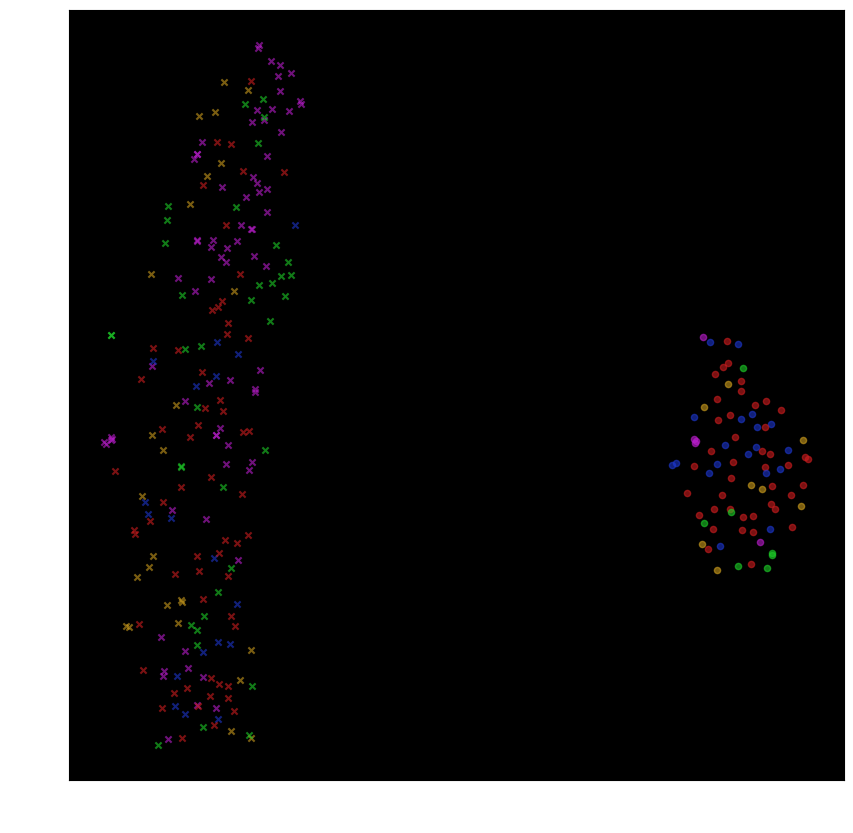

In [15]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
plt.gca().set_facecolor('black')
# Adjust the color of the ticks and labels for better visibility
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Component 1', color='white')
plt.ylabel('Component 2', color='white')

plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import torch
# from sklearn.preprocessing import MinMaxScaler

# X = torch.stack(plot_data).cpu().numpy()
# labelsNums = plot_labels

# # Perform t-SNE dimensionality reduction
# X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# # Normalize the points
# scaler = MinMaxScaler()
# X_embedded_normalized = scaler.fit_transform(X_embedded)

# # Create the scatter plot
# plt.figure(figsize=(10, 10))
# for i in range(len(X_embedded_normalized)):
#     marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
#     plt.scatter(X_embedded_normalized[i, 0], X_embedded_normalized[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# # Set the background color to black
# plt.gca().set_facecolor('black')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')

# plt.show()


In [16]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [ ]:
# class TripletLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         distance_positive = (anchor - positive).pow(2).sum(1)
#         distance_negative = (anchor - negative).pow(2).sum(1)
#         losses = torch.relu(distance_positive - distance_negative + self.margin)
#         return losses.mean()

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedTripletLoss(nn.Module):
    def __init__(self, margin=1.0, class_weights=None):
        super(WeightedTripletLoss, self).__init__()
        self.margin = margin
        self.class_weights = class_weights if class_weights is not None else torch.ones(1).to(device)

    def forward(self, anchor, positive, negative, labels):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        # Apply class-specific weights
        if self.class_weights is not None:
            labels = labels.to(self.class_weights.device)
            weights = self.class_weights[labels]
            losses = losses * weights

        return losses.mean()

In [27]:
learning_rate = 5e-6
num_epochs = 200
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = WeightedTripletLoss(margin=1.0, class_weights=class_weights_tensor)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
# class_weights = torch.tensor([1.0, 2.0, 0.5, 1.5, 1.0])
triplet_loss = WeightedTripletLoss(margin=margin, class_weights=class_weights_tensor)

In [ ]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [43]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

best_loss = 100.0
num_epochs = 400
writer = SummaryWriter('logs/flakyXbert++_369')
epoch_loss_list = []

for epoch in range(num_epochs):
    total_loss = 0.01
    siamese_network.train()
    
    for i, batch in enumerate(tqdm(train_dataloader)):
        labels = batch['label'].to(device)
        batch_anchor = batch['anchor'].to(device)
        batch_positive = batch['positive'].to(device)
        batch_negative = batch['negative'].to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_dataloader) + i)
        total_loss += loss.item()
        
        if total_loss <= best_loss:
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'flakyXbert++_369dp.pth')
            best_loss = total_loss

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")

  3%|▎         | 1/37 [00:00<00:10,  3.38it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.46it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.46it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.49it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 1/400, Loss: 0.26347613561797784


  3%|▎         | 1/37 [00:00<00:12,  2.99it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.69it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.39it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 2/400, Loss: 0.2657031855933569


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 3/400, Loss: 0.2938683692526978


  3%|▎         | 1/37 [00:00<00:17,  2.04it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.82it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.27it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.78it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  2.91it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.95it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.13it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 4/400, Loss: 0.17415727660462663


  3%|▎         | 1/37 [00:00<00:09,  3.91it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.51it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 5/400, Loss: 0.2542059678846114


  3%|▎         | 1/37 [00:00<00:11,  3.11it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.85it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.78it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.14it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 6/400, Loss: 0.22892659606160343


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 7/400, Loss: 0.262697627673278


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 8/400, Loss: 0.2876516349573393


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 9/400, Loss: 0.48445377816622315


  3%|▎         | 1/37 [00:00<00:10,  3.58it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.77it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  2.88it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 10/400, Loss: 0.26768376069697175


  3%|▎         | 1/37 [00:00<00:22,  1.58it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.26it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.51it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.75it/s]


Epoch 11/400, Loss: 0.21303638771176336


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 12/400, Loss: 0.16129399174201378


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 13/400, Loss: 0.1587040802127858


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 14/400, Loss: 0.31711576491997046


  3%|▎         | 1/37 [00:00<00:26,  1.34it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:17,  1.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 15/400, Loss: 0.25113036392256616


  3%|▎         | 1/37 [00:00<00:23,  1.52it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.20it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 16/400, Loss: 0.3300925902075864


  3%|▎         | 1/37 [00:00<00:10,  3.52it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 17/400, Loss: 0.3904844229044141


  3%|▎         | 1/37 [00:00<00:09,  3.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 18/400, Loss: 0.34853771304359304


  3%|▎         | 1/37 [00:00<00:19,  1.86it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 19/400, Loss: 0.23967376961095913


  3%|▎         | 1/37 [00:00<00:12,  2.96it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 20/400, Loss: 0.25428970727566125


  3%|▎         | 1/37 [00:00<00:12,  2.96it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.15it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.71it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 21/400, Loss: 0.18284237189067376


  3%|▎         | 1/37 [00:00<00:13,  2.58it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:17,  2.04it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.30it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 22/400, Loss: 0.30997999602072945


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 23/400, Loss: 0.07309907106531632


  3%|▎         | 1/37 [00:00<00:10,  3.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 24/400, Loss: 0.268270518435417


  3%|▎         | 1/37 [00:00<00:11,  3.09it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.66it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 25/400, Loss: 0.11247484600523838


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 26/400, Loss: 0.21037371950576433


  3%|▎         | 1/37 [00:00<00:12,  2.87it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:19,  1.83it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.23it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 27/400, Loss: 0.17285850873770744


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 28/400, Loss: 0.2664404974152913


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 29/400, Loss: 0.23031210473939978


  3%|▎         | 1/37 [00:00<00:11,  3.08it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.74it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 30/400, Loss: 0.19936263506476942


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.28it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 31/400, Loss: 0.229409503983082


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 32/400, Loss: 0.2504536441361179


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 33/400, Loss: 0.2475611502616792


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 34/400, Loss: 0.12236520754324423


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 35/400, Loss: 0.39208940467520337


  3%|▎         | 1/37 [00:00<00:09,  3.66it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.09it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 36/400, Loss: 0.17699574125981007


  3%|▎         | 1/37 [00:00<00:19,  1.87it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.72it/s]


Epoch 37/400, Loss: 0.20808965924825218


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 38/400, Loss: 0.17341252009208138


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 39/400, Loss: 0.11429968791535576


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.02it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 40/400, Loss: 0.10218917533755302


  3%|▎         | 1/37 [00:00<00:15,  2.32it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.45it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.55it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.51it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.59it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  3.16it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 41/400, Loss: 0.18936625006583493


  3%|▎         | 1/37 [00:00<00:10,  3.32it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 42/400, Loss: 0.13356050328527752


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 43/400, Loss: 0.2664252112277255


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 44/400, Loss: 0.2382005542275068


  3%|▎         | 1/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 45/400, Loss: 0.19506215886187714


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 46/400, Loss: 0.19230062528676983


  3%|▎         | 1/37 [00:00<00:12,  2.94it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.84it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.12it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.58it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.64it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 47/400, Loss: 0.138517627297221


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 48/400, Loss: 0.22815390561078044


  3%|▎         | 1/37 [00:00<00:09,  3.89it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 49/400, Loss: 0.23699625383257059


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 50/400, Loss: 0.14443661852060136


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 51/400, Loss: 0.26125269086779773


  3%|▎         | 1/37 [00:00<00:16,  2.20it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 52/400, Loss: 0.3101839226152043


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 53/400, Loss: 0.3071342140395899


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 54/400, Loss: 0.1489110166846296


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 55/400, Loss: 0.08435585420880769


  3%|▎         | 1/37 [00:00<00:15,  2.34it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 56/400, Loss: 0.15329020815825944


  3%|▎         | 1/37 [00:00<00:09,  3.67it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.38it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.15it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.73it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:14,  2.28it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.49it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.70it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 57/400, Loss: 0.14521992100201345


  3%|▎         | 1/37 [00:00<00:16,  2.20it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.10it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.38it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.63it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:08,  3.64it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 58/400, Loss: 0.19275099407176713


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 59/400, Loss: 0.20245899293370342


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 60/400, Loss: 0.20629541954075967


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 61/400, Loss: 0.13252828295971897


  3%|▎         | 1/37 [00:00<00:12,  2.89it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.19it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.48it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.68it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.69it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  3.08it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.69it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 62/400, Loss: 0.05876474083074041


  3%|▎         | 1/37 [00:00<00:12,  2.91it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 63/400, Loss: 0.09065055847772069


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 64/400, Loss: 0.29173143032434823


  3%|▎         | 1/37 [00:00<00:08,  4.01it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 65/400, Loss: 0.246049134167465


  3%|▎         | 1/37 [00:00<00:09,  3.92it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.59it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 66/400, Loss: 0.11626157297324892


  3%|▎         | 1/37 [00:00<00:15,  2.31it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.10it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 67/400, Loss: 0.13666571546446632


  3%|▎         | 1/37 [00:00<00:15,  2.30it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 68/400, Loss: 0.11155343809567794


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 69/400, Loss: 0.2485784530398008


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 70/400, Loss: 0.4594789859773339


  3%|▎         | 1/37 [00:00<00:09,  3.67it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.22it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 71/400, Loss: 0.13196978643133833


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 72/400, Loss: 0.13856974503981906


  3%|▎         | 1/37 [00:00<00:15,  2.30it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.71it/s]

Loss improved saving model
Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.12it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:13,  2.34it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.68it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.83it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 73/400, Loss: 0.20494595457573195


  3%|▎         | 1/37 [00:00<00:13,  2.76it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.57it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.63it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.61it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 74/400, Loss: 0.14442279093993224


  3%|▎         | 1/37 [00:00<00:11,  3.09it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 75/400, Loss: 0.06520177930492807


  3%|▎         | 1/37 [00:00<00:11,  3.14it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.62it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.23it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 76/400, Loss: 0.10866391201277037


  3%|▎         | 1/37 [00:00<00:09,  3.89it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.97it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 77/400, Loss: 0.0668932323379291


  3%|▎         | 1/37 [00:00<00:15,  2.36it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 78/400, Loss: 0.2143916917169416


  3%|▎         | 1/37 [00:00<00:18,  1.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 79/400, Loss: 0.6396665652217092


  3%|▎         | 1/37 [00:00<00:14,  2.42it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 80/400, Loss: 0.22577698708083985


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 81/400, Loss: 0.12242648675635054


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 82/400, Loss: 0.21923971144029417


100%|██████████| 37/37 [00:13<00:00,  2.79it/s]


Epoch 83/400, Loss: 0.09927921390412627


  3%|▎         | 1/37 [00:00<00:13,  2.63it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 84/400, Loss: 0.14249637617855457


  3%|▎         | 1/37 [00:00<00:06,  5.31it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.35it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 85/400, Loss: 0.12319050513409278


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 86/400, Loss: 0.142173796294106


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 87/400, Loss: 0.12142420988630603


  3%|▎         | 1/37 [00:00<00:16,  2.21it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:21,  1.62it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:17,  1.99it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 88/400, Loss: 0.08921213161703702


  3%|▎         | 1/37 [00:00<00:15,  2.34it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.38it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.85it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.81it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:13,  2.36it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:13,  2.35it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.61it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:10,  2.65it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 89/400, Loss: 0.14195997152779552


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 90/400, Loss: 0.08664818778231337


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 91/400, Loss: 0.14407817212008947


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 92/400, Loss: 0.1829357588774449


  3%|▎         | 1/37 [00:00<00:09,  3.65it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.20it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.67it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 93/400, Loss: 0.09993861953551704


  3%|▎         | 1/37 [00:00<00:11,  3.26it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 94/400, Loss: 0.10002678980698457


  3%|▎         | 1/37 [00:00<00:19,  1.89it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.33it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 95/400, Loss: 0.12067980022849263


  3%|▎         | 1/37 [00:00<00:09,  3.80it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 96/400, Loss: 0.08963827102583505


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:08,  4.03it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  2.91it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 97/400, Loss: 0.1443994260277297


  3%|▎         | 1/37 [00:00<00:11,  3.09it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 98/400, Loss: 0.21094077005579664


  3%|▎         | 1/37 [00:00<00:22,  1.59it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.26it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.79it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.96it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.36it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:09,  3.20it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.22it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  3.02it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:09,  3.05it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:10,  2.66it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:09,  2.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 99/400, Loss: 0.07150751176718119


  3%|▎         | 1/37 [00:00<00:14,  2.49it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 100/400, Loss: 0.11375655487431464


  3%|▎         | 1/37 [00:00<00:14,  2.45it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.56it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 101/400, Loss: 0.21101112870751199


  3%|▎         | 1/37 [00:00<00:09,  3.90it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.98it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.17it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.37it/s]

Loss improved saving model
Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  3.10it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.12it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 102/400, Loss: 0.049740172626601686


  3%|▎         | 1/37 [00:00<00:11,  3.03it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.27it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.89it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.94it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 103/400, Loss: 0.15239190215194548


100%|██████████| 37/37 [00:10<00:00,  3.36it/s]


Epoch 104/400, Loss: 0.0995530849917968


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 105/400, Loss: 0.10399926912542935


  3%|▎         | 1/37 [00:00<00:08,  4.01it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.30it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.08it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:16,  2.05it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:15,  2.06it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 106/400, Loss: 0.2060514220122147


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 107/400, Loss: 0.2813819465287835


  3%|▎         | 1/37 [00:00<00:15,  2.35it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.34it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.49it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 108/400, Loss: 0.2437911855771735


  3%|▎         | 1/37 [00:00<00:12,  2.96it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.95it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.88it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.97it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 109/400, Loss: 0.15016393807087394


  3%|▎         | 1/37 [00:00<00:19,  1.89it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.14it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 110/400, Loss: 0.14338637904138177


  3%|▎         | 1/37 [00:00<00:12,  2.95it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.25it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.91it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 111/400, Loss: 0.3761844315399995


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 112/400, Loss: 0.26275667151083815


  3%|▎         | 1/37 [00:00<00:15,  2.31it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.94it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.83it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.31it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.85it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 113/400, Loss: 0.09882233116272333


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 114/400, Loss: 0.09142334936035645


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 115/400, Loss: 0.1627474440875891


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 116/400, Loss: 0.08667712563598477


  3%|▎         | 1/37 [00:00<00:09,  3.63it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.03it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.40it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 117/400, Loss: 0.12676145358464203


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 118/400, Loss: 0.17219419903851843


  3%|▎         | 1/37 [00:00<00:16,  2.23it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 119/400, Loss: 0.15467262384456557


  3%|▎         | 1/37 [00:00<00:11,  3.03it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.82it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 120/400, Loss: 0.14684889098679696


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 121/400, Loss: 0.10714443839079624


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 122/400, Loss: 0.22826571717858313


  3%|▎         | 1/37 [00:00<00:16,  2.15it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.76it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:10,  3.16it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 123/400, Loss: 0.18151186954683146


  3%|▎         | 1/37 [00:00<00:16,  2.19it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.99it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.55it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.78it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.52it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 124/400, Loss: 0.07964690281934028


  3%|▎         | 1/37 [00:00<00:09,  3.67it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.04it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 125/400, Loss: 0.17324706514944901


  5%|▌         | 2/37 [00:00<00:08,  3.98it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 126/400, Loss: 0.17033869330746096


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 127/400, Loss: 0.06802324961367491


  3%|▎         | 1/37 [00:00<00:14,  2.44it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.57it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 128/400, Loss: 0.11012610255060969


  3%|▎         | 1/37 [00:00<00:12,  2.86it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:17,  1.97it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.00it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.79it/s]


Epoch 129/400, Loss: 0.19055021101759897


  3%|▎         | 1/37 [00:00<00:11,  3.05it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.03it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.12it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 130/400, Loss: 0.23783561479702994


  3%|▎         | 1/37 [00:00<00:12,  2.87it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.43it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 131/400, Loss: 0.16483963195939322


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 132/400, Loss: 0.11387740237285962


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 133/400, Loss: 0.11107689565072792


  3%|▎         | 1/37 [00:00<00:11,  3.20it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 134/400, Loss: 0.1049370981712599


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.87it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.82it/s]

Loss improved saving model
Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.12it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:09,  3.28it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.04it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.72it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:02<00:09,  3.07it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.94it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:08,  2.97it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:10,  2.42it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.68it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 135/400, Loss: 0.05136722130549921


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 136/400, Loss: 0.11612908869981765


  3%|▎         | 1/37 [00:00<00:11,  3.25it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.07it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.57it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.73it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 137/400, Loss: 0.05192893759221644


  3%|▎         | 1/37 [00:00<00:10,  3.60it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.46it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  2.90it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.15it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.32it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  2.95it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.60it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:12,  2.27it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:12,  2.31it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:10,  2.55it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:09,  2.86it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:09,  2.55it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.76it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:07,  2.94it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:07,  2.80it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:05<00:08,  2.45it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:08,  2.28it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:07<00:09,  2.03it/s]

Loss improved saving model


 51%|█████▏    | 19/37 [00:07<00:07,  2.36it/s]

Loss improved saving model


 54%|█████▍    | 20/37 [00:07<00:07,  2.34it/s]

Loss improved saving model


 57%|█████▋    | 21/37 [00:08<00:07,  2.21it/s]

Loss improved saving model


 59%|█████▉    | 22/37 [00:08<00:05,  2.60it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.70it/s]


Epoch 138/400, Loss: 0.14893908703649367


100%|██████████| 37/37 [00:13<00:00,  2.76it/s]


Epoch 139/400, Loss: 0.11179893091925092


  3%|▎         | 1/37 [00:00<00:15,  2.33it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 140/400, Loss: 0.269423966125862


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 141/400, Loss: 0.3230687601149485


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 142/400, Loss: 0.21412418123838065


  3%|▎         | 1/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 143/400, Loss: 0.05523833247958808


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 144/400, Loss: 0.11125672483363666


  3%|▎         | 1/37 [00:00<00:14,  2.49it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.14it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  3.07it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.93it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  2.96it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.92it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.87it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.88it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:11,  2.42it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:11,  2.30it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:10,  2.47it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  2.83it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 145/400, Loss: 0.09130975327781728


  3%|▎         | 1/37 [00:00<00:15,  2.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 146/400, Loss: 0.07470441529678332


  3%|▎         | 1/37 [00:00<00:16,  2.17it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 147/400, Loss: 0.13299524769589707


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 148/400, Loss: 0.12129992795957101


  3%|▎         | 1/37 [00:00<00:09,  3.63it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.55it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 149/400, Loss: 0.07573126230011316


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.74it/s]


Epoch 150/400, Loss: 0.06913680025049157


  3%|▎         | 1/37 [00:00<00:10,  3.56it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.18it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.47it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.57it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 151/400, Loss: 0.0186893218383193


  3%|▎         | 1/37 [00:00<00:29,  1.24it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:16,  2.08it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.78it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.33it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.22it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:08,  3.57it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:08,  3.41it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 152/400, Loss: 0.05972319262429467


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 153/400, Loss: 0.17253405882045625


  3%|▎         | 1/37 [00:00<00:23,  1.53it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.32it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.85it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.83it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:13,  2.37it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.58it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.51it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:11,  2.55it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.76it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 154/400, Loss: 0.08183077768699543


  3%|▎         | 1/37 [00:00<00:16,  2.17it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:17,  1.99it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.15it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 155/400, Loss: 0.06494723281143484


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.06it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  3.09it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.23it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.56it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  2.83it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.53it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 156/400, Loss: 0.11824339915771742


  3%|▎         | 1/37 [00:00<00:13,  2.73it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.22it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 157/400, Loss: 0.19826667147311003


  3%|▎         | 1/37 [00:00<00:18,  1.94it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 158/400, Loss: 0.03870798990646428


  3%|▎         | 1/37 [00:00<00:06,  5.95it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 159/400, Loss: 0.05873511921010307


  5%|▌         | 2/37 [00:00<00:08,  4.03it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 160/400, Loss: 0.1003205192814002


  3%|▎         | 1/37 [00:00<00:04,  8.19it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 161/400, Loss: 0.10090620630093522


  3%|▎         | 1/37 [00:00<00:16,  2.13it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 162/400, Loss: 0.03290451368971451


  3%|▎         | 1/37 [00:00<00:11,  3.17it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.37it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 163/400, Loss: 0.0753983257751207


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 164/400, Loss: 0.054429230374359594


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 165/400, Loss: 0.14606866342123326


  3%|▎         | 1/37 [00:00<00:13,  2.72it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.71it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.43it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.80it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.51it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.60it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 166/400, Loss: 0.12442101312247482


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 167/400, Loss: 0.34239460357338997


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.85it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 168/400, Loss: 0.12260456870888939


  3%|▎         | 1/37 [00:00<00:10,  3.33it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 169/400, Loss: 0.06099241443985217


  3%|▎         | 1/37 [00:00<00:10,  3.32it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.73it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.20it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:15,  2.14it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 170/400, Loss: 0.3252156774095587


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 171/400, Loss: 0.3542203565465437


  3%|▎         | 1/37 [00:00<00:14,  2.54it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.02it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.50it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.52it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.75it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 172/400, Loss: 0.29266398013040823


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 173/400, Loss: 0.21819399010893462


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 174/400, Loss: 0.0993710481496276


  3%|▎         | 1/37 [00:00<00:12,  2.84it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 175/400, Loss: 0.05182307093328721


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 176/400, Loss: 0.06933646423188415


  3%|▎         | 1/37 [00:00<00:16,  2.17it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.49it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 177/400, Loss: 0.1605020887908098


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 178/400, Loss: 0.5865088146038957


  3%|▎         | 1/37 [00:00<00:10,  3.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 179/400, Loss: 0.18896614926892358


  3%|▎         | 1/37 [00:00<00:14,  2.44it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 180/400, Loss: 0.11198710293383211


  3%|▎         | 1/37 [00:00<00:14,  2.49it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.46it/s]

Loss improved saving model
Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 181/400, Loss: 0.07965997803452853


100%|██████████| 37/37 [00:13<00:00,  2.79it/s]


Epoch 182/400, Loss: 0.06499459275422063


  3%|▎         | 1/37 [00:00<00:15,  2.33it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.42it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.67it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 183/400, Loss: 0.03216477710652996


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.66it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.29it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 184/400, Loss: 0.042585902979245055


  3%|▎         | 1/37 [00:00<00:12,  2.89it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 185/400, Loss: 0.0567797314234682


  3%|▎         | 1/37 [00:00<00:11,  3.09it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.76it/s]


Epoch 186/400, Loss: 0.09904450025208092


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 187/400, Loss: 0.14087306864761018


  3%|▎         | 1/37 [00:00<00:15,  2.35it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.76it/s]


Epoch 188/400, Loss: 0.03895769636373262


  3%|▎         | 1/37 [00:00<00:16,  2.21it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.66it/s]

Loss improved saving model
Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.96it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.03it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:09,  3.19it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.29it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.74it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.58it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.71it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:10,  2.60it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:09,  2.69it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 189/400, Loss: 0.014569343476480728


  3%|▎         | 1/37 [00:00<00:12,  2.88it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.32it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.14it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 190/400, Loss: 0.06658991492277866


  3%|▎         | 1/37 [00:00<00:16,  2.14it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:22,  1.52it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:17,  1.97it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.41it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:12,  2.52it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:13,  2.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 191/400, Loss: 0.13009294651650094


  3%|▎         | 1/37 [00:00<00:22,  1.64it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.19it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.32it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.35it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:13,  2.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 192/400, Loss: 0.051589400740088644


  3%|▎         | 1/37 [00:00<00:17,  2.10it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.83it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 193/400, Loss: 0.11662410633185424


  3%|▎         | 1/37 [00:00<00:18,  1.90it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.23it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.41it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.31it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.08it/s]


Epoch 194/400, Loss: 0.16871690171795922


  3%|▎         | 1/37 [00:00<00:23,  1.56it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.29it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 195/400, Loss: 0.06286594478665171


  3%|▎         | 1/37 [00:00<00:16,  2.19it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:18,  1.88it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.77it/s]


Epoch 196/400, Loss: 0.07348791898102373


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 197/400, Loss: 0.35135225166944234


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 198/400, Loss: 1.0862146312985066


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 199/400, Loss: 0.4601718575024121


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 200/400, Loss: 0.09356828704073622


  3%|▎         | 1/37 [00:00<00:15,  2.34it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 201/400, Loss: 0.12601620764949836


  3%|▎         | 1/37 [00:00<00:12,  2.92it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.89it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.12it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.92it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 202/400, Loss: 0.1656677052942482


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 203/400, Loss: 0.18368838914342828


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 204/400, Loss: 0.22899737703035006


  3%|▎         | 1/37 [00:00<00:10,  3.33it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.87it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.86it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 205/400, Loss: 0.07721975823914681


  3%|▎         | 1/37 [00:00<00:13,  2.60it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 206/400, Loss: 0.10060018618767326


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 207/400, Loss: 0.10236567273282923


  3%|▎         | 1/37 [00:00<00:10,  3.42it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 208/400, Loss: 0.06629968611372483


  3%|▎         | 1/37 [00:00<00:12,  2.95it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 209/400, Loss: 0.14305445451792834


  3%|▎         | 1/37 [00:00<00:10,  3.54it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.75it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 210/400, Loss: 0.057352281458474486


  3%|▎         | 1/37 [00:00<00:17,  2.07it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.58it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 211/400, Loss: 0.10420112810827589


  3%|▎         | 1/37 [00:00<00:10,  3.29it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  3.01it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.71it/s]


Epoch 212/400, Loss: 0.089102980208558


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 213/400, Loss: 0.28829523131251333


  3%|▎         | 1/37 [00:00<00:17,  2.11it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.35it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.56it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.58it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 214/400, Loss: 0.18964454094300398


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 215/400, Loss: 0.08813208810380986


  3%|▎         | 1/37 [00:00<00:11,  3.27it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.00it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 216/400, Loss: 0.19283474232296685


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 217/400, Loss: 0.189414233831135


  3%|▎         | 1/37 [00:00<00:15,  2.30it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.31it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.02it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.41it/s]

Loss improved saving model
Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.64it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.72it/s]


Epoch 218/400, Loss: 0.050414086552085104


  3%|▎         | 1/37 [00:00<00:09,  3.82it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.60it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.64it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.83it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 219/400, Loss: 0.055451395600228694


  3%|▎         | 1/37 [00:00<00:11,  3.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 220/400, Loss: 0.2468235444564473


  3%|▎         | 1/37 [00:00<00:11,  3.24it/s]

Loss improved saving model
Loss improved saving model


  8%|▊         | 3/37 [00:00<00:08,  3.84it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:08,  3.83it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:08,  3.72it/s]

Loss improved saving model
Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.32it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  3.22it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:02<00:09,  3.02it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 221/400, Loss: 0.07283327895241815


  3%|▎         | 1/37 [00:00<00:15,  2.27it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.61it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 222/400, Loss: 0.12748084259446005


  3%|▎         | 1/37 [00:00<00:06,  5.59it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:08,  4.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 223/400, Loss: 0.06899454707028092


  3%|▎         | 1/37 [00:00<00:16,  2.21it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.75it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.34it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 224/400, Loss: 0.02688229304785538


  3%|▎         | 1/37 [00:00<00:16,  2.15it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.39it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.76it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.73it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.08it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.78it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:13,  2.18it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:13,  2.08it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:13,  2.11it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:04<00:12,  2.13it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.79it/s]


Epoch 225/400, Loss: 0.07654055710730923


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 226/400, Loss: 0.06560306581391676


  3%|▎         | 1/37 [00:00<00:13,  2.62it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.54it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.33it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 227/400, Loss: 0.02858758652935157


  3%|▎         | 1/37 [00:00<00:10,  3.30it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 228/400, Loss: 0.021505368879517994


  3%|▎         | 1/37 [00:00<00:16,  2.22it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 229/400, Loss: 0.09468555705269446


100%|██████████| 37/37 [00:13<00:00,  2.76it/s]


Epoch 230/400, Loss: 0.0974739313286704


  3%|▎         | 1/37 [00:00<00:11,  3.10it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 231/400, Loss: 0.022987918531572497


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 232/400, Loss: 0.04613832651763349


  3%|▎         | 1/37 [00:00<00:20,  1.77it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 233/400, Loss: 0.09132855904666153


  3%|▎         | 1/37 [00:00<00:19,  1.84it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.52it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 234/400, Loss: 0.01980804400870929


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 235/400, Loss: 0.04638730236807385


  3%|▎         | 1/37 [00:00<00:12,  2.85it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.42it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.69it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 236/400, Loss: 0.028340626413355004


  3%|▎         | 1/37 [00:00<00:13,  2.63it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.44it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.86it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.23it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.54it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:13,  2.31it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.59it/s]

Loss improved saving model
Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:09,  2.93it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.76it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:08,  2.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 237/400, Loss: 0.04578236163870708


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 238/400, Loss: 0.13901168657315743


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.20it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.74it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.76it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:08,  3.58it/s]

Loss improved saving model
Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.28it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:08,  3.27it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:02<00:08,  3.29it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:02<00:07,  3.53it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:07,  3.51it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:03<00:06,  3.61it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 239/400, Loss: 0.07660754914118631


  3%|▎         | 1/37 [00:00<00:16,  2.23it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.26it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 240/400, Loss: 0.05775528920260635


  3%|▎         | 1/37 [00:00<00:14,  2.54it/s]

Loss improved saving model
Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.32it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.50it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 241/400, Loss: 0.03203835676248009


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.41it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 242/400, Loss: 0.03828556448623941


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 243/400, Loss: 0.060091614905442736


  3%|▎         | 1/37 [00:00<00:10,  3.42it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.78it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  2.87it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.85it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.82it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.57it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.85it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.86it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 244/400, Loss: 0.05889839241633543


  3%|▎         | 1/37 [00:00<00:09,  3.88it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.76it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.28it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 245/400, Loss: 0.04701083189329586


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 246/400, Loss: 0.009974366664081007


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 247/400, Loss: 0.06843254207356556


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 248/400, Loss: 0.17526788114091835


  3%|▎         | 1/37 [00:00<00:12,  2.85it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.94it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.71it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.53it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.46it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.65it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.69it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:08,  3.12it/s]

Loss improved saving model
Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:08,  3.18it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  3.05it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:07,  3.07it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:04<00:08,  2.81it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:07,  2.98it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 249/400, Loss: 0.06531197160482406


  3%|▎         | 1/37 [00:00<00:09,  3.64it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.26it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.11it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.56it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.71it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.65it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 250/400, Loss: 0.03635631124715547


  3%|▎         | 1/37 [00:00<00:20,  1.74it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.16it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.84it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.68it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:13,  2.33it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.54it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:11,  2.54it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:11,  2.47it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:04<00:10,  2.47it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:09,  2.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 251/400, Loss: 0.017536272930132376


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 252/400, Loss: 0.06910621018023104


  3%|▎         | 1/37 [00:00<00:15,  2.39it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.67it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  3.03it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.23it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:13,  2.36it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.81it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.68it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 253/400, Loss: 0.03440896467582599


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 254/400, Loss: 0.017815073756752786


  3%|▎         | 1/37 [00:00<00:09,  3.61it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.12it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.89it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.49it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.48it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.78it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.95it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 255/400, Loss: 0.3736638364920745


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 256/400, Loss: 0.1780811185329347


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 257/400, Loss: 0.09930306668619851


  3%|▎         | 1/37 [00:00<00:16,  2.18it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.82it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:10,  3.10it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.19it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.27it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.79it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 258/400, Loss: 0.125967484325976


  3%|▎         | 1/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 259/400, Loss: 0.11284685598635995


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 260/400, Loss: 0.19838681578535486


  3%|▎         | 1/37 [00:00<00:11,  3.01it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.70it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 261/400, Loss: 0.05396401594883787


  3%|▎         | 1/37 [00:00<00:17,  2.11it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 262/400, Loss: 0.1178495485924587


  3%|▎         | 1/37 [00:00<00:10,  3.28it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.06it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.36it/s]

Loss improved saving model
Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.10it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  2.95it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.80it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:12,  2.30it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 263/400, Loss: 0.0408169581439044


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 264/400, Loss: 0.1168655447873312


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 265/400, Loss: 0.04641951324166478


  3%|▎         | 1/37 [00:00<00:13,  2.59it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.74it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 266/400, Loss: 0.03611402818278686


  3%|▎         | 1/37 [00:00<00:11,  3.24it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.83it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 267/400, Loss: 0.07133068240574887


  3%|▎         | 1/37 [00:00<00:13,  2.73it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.63it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.21it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 268/400, Loss: 0.0698685970821896


  3%|▎         | 1/37 [00:00<00:12,  2.92it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.24it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.08it/s]


Epoch 269/400, Loss: 0.10685541003137021


  3%|▎         | 1/37 [00:00<00:17,  2.06it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.15it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 270/400, Loss: 0.014037599994524105


  3%|▎         | 1/37 [00:00<00:19,  1.83it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:17,  2.04it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.34it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.42it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:15,  2.07it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:14,  2.19it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:03<00:13,  2.27it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:11,  2.50it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:04<00:12,  2.19it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 271/400, Loss: 0.06297987765557056


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 272/400, Loss: 0.052753281005330985


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 273/400, Loss: 0.04568758078926318


  3%|▎         | 1/37 [00:00<00:19,  1.82it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.31it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.06it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 274/400, Loss: 0.024454801374593296


  3%|▎         | 1/37 [00:00<00:21,  1.66it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.20it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.79it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.22it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:14,  2.17it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.44it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.62it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:10,  2.75it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:09,  2.95it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:08,  3.24it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:07,  3.31it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  3.07it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:07,  3.11it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:07,  3.22it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:07,  2.99it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:05<00:06,  3.20it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:05<00:05,  3.40it/s]

Loss improved saving model


 51%|█████▏    | 19/37 [00:06<00:05,  3.01it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 275/400, Loss: 0.007688423725398811


  3%|▎         | 1/37 [00:00<00:11,  3.09it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.81it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.74it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 276/400, Loss: 0.01318005014915724


  3%|▎         | 1/37 [00:00<00:13,  2.66it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.87it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.93it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  3.00it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  2.94it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:09,  3.32it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.11it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  3.18it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:02<00:09,  3.02it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:08,  3.20it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:09,  2.79it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:09,  2.73it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.79it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:04<00:07,  2.94it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:08,  2.47it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:05<00:07,  2.65it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:09,  2.10it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:06<00:08,  2.29it/s]

Loss improved saving model


 51%|█████▏    | 19/37 [00:06<00:07,  2.45it/s]

Loss improved saving model


 54%|█████▍    | 20/37 [00:07<00:06,  2.70it/s]

Loss improved saving model


 57%|█████▋    | 21/37 [00:07<00:05,  3.08it/s]

Loss improved saving model


 59%|█████▉    | 22/37 [00:07<00:04,  3.13it/s]

Loss improved saving model


 62%|██████▏   | 23/37 [00:08<00:04,  3.29it/s]

Loss improved saving model


 65%|██████▍   | 24/37 [00:08<00:04,  3.10it/s]

Loss improved saving model


 68%|██████▊   | 25/37 [00:08<00:04,  2.70it/s]

Loss improved saving model


 70%|███████   | 26/37 [00:09<00:04,  2.73it/s]

Loss improved saving model


 73%|███████▎  | 27/37 [00:09<00:03,  2.88it/s]

Loss improved saving model


 76%|███████▌  | 28/37 [00:10<00:03,  2.51it/s]

Loss improved saving model


 78%|███████▊  | 29/37 [00:10<00:03,  2.43it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 277/400, Loss: 0.011209140210538298


  3%|▎         | 1/37 [00:00<00:11,  3.25it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.75it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  2.88it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.96it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 278/400, Loss: 0.009451453907264245


  3%|▎         | 1/37 [00:00<00:13,  2.66it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.41it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  3.05it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.15it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.76it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.97it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.84it/s]

Loss improved saving model
Loss improved saving model


 24%|██▍       | 9/37 [00:02<00:07,  3.86it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:07,  3.49it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:07,  3.56it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 279/400, Loss: 0.035379060021526104


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.05it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.47it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:15,  2.13it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:13,  2.33it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 280/400, Loss: 0.0197672883889361


  3%|▎         | 1/37 [00:00<00:14,  2.57it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.93it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.51it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.41it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.75it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.97it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.90it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:08,  3.26it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:08,  3.16it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:07,  3.38it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:07,  3.42it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 281/400, Loss: 0.00992409170680755


  3%|▎         | 1/37 [00:00<00:11,  3.18it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.21it/s]

Loss improved saving model
Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.30it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 282/400, Loss: 0.011128329325568032


  3%|▎         | 1/37 [00:00<00:18,  1.91it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:10,  3.11it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.79it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 283/400, Loss: 0.016107351651062838


  3%|▎         | 1/37 [00:00<00:10,  3.58it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.21it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.76it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.86it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.21it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:09,  3.41it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.92it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:11,  2.62it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:11,  2.40it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.76it/s]


Epoch 284/400, Loss: 0.08641752143163939


  3%|▎         | 1/37 [00:00<00:10,  3.41it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 285/400, Loss: 0.19145107264857034


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 286/400, Loss: 0.24827441546059137


  3%|▎         | 1/37 [00:00<00:10,  3.33it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.60it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 287/400, Loss: 0.07558383828482111


  3%|▎         | 1/37 [00:00<00:15,  2.32it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 288/400, Loss: 0.0385664987966821


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 289/400, Loss: 0.02932355329495024


  3%|▎         | 1/37 [00:00<00:11,  3.11it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.24it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.49it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.45it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.59it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.86it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 290/400, Loss: 0.03754239434326017


  3%|▎         | 1/37 [00:00<00:14,  2.54it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.92it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.40it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.87it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 291/400, Loss: 0.036585595817179295


  3%|▎         | 1/37 [00:00<00:12,  2.99it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.44it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.32it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.30it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.61it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:13,  2.36it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.57it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.73it/s]

Loss improved saving model
Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:08,  3.19it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:08,  3.07it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  2.92it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:09,  2.58it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:04<00:08,  2.79it/s]

Loss improved saving model
Loss improved saving model


 43%|████▎     | 16/37 [00:05<00:08,  2.54it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:08,  2.40it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:06<00:06,  2.78it/s]

Loss improved saving model
Loss improved saving model


 54%|█████▍    | 20/37 [00:06<00:05,  3.21it/s]

Loss improved saving model


 57%|█████▋    | 21/37 [00:07<00:05,  3.15it/s]

Loss improved saving model


 59%|█████▉    | 22/37 [00:07<00:04,  3.29it/s]

Loss improved saving model


 62%|██████▏   | 23/37 [00:07<00:04,  3.44it/s]

Loss improved saving model


 65%|██████▍   | 24/37 [00:08<00:04,  2.92it/s]

Loss improved saving model


 68%|██████▊   | 25/37 [00:08<00:04,  2.88it/s]

Loss improved saving model


 70%|███████   | 26/37 [00:08<00:03,  2.99it/s]

Loss improved saving model


 73%|███████▎  | 27/37 [00:09<00:03,  2.97it/s]

Loss improved saving model


 76%|███████▌  | 28/37 [00:09<00:03,  2.68it/s]

Loss improved saving model


 78%|███████▊  | 29/37 [00:09<00:02,  2.88it/s]

Loss improved saving model


 81%|████████  | 30/37 [00:10<00:02,  2.58it/s]

Loss improved saving model


 84%|████████▍ | 31/37 [00:10<00:02,  2.36it/s]

Loss improved saving model


 86%|████████▋ | 32/37 [00:11<00:01,  2.78it/s]

Loss improved saving model


 89%|████████▉ | 33/37 [00:11<00:01,  3.14it/s]

Loss improved saving model


 92%|█████████▏| 34/37 [00:11<00:00,  3.30it/s]

Loss improved saving model


 95%|█████████▍| 35/37 [00:11<00:00,  3.29it/s]

Loss improved saving model


 97%|█████████▋| 36/37 [00:12<00:00,  3.14it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 292/400, Loss: 0.020372859787296603


  3%|▎         | 1/37 [00:00<00:23,  1.51it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:18,  1.85it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:18,  1.86it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 293/400, Loss: 0.15585043145998104


  3%|▎         | 1/37 [00:00<00:10,  3.56it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.88it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.21it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.46it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.02it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.54it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:13,  2.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 294/400, Loss: 0.017026172755537805


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 295/400, Loss: 0.053296052479260676


  3%|▎         | 1/37 [00:00<00:09,  3.67it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.66it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  3.05it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.87it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  2.98it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 296/400, Loss: 0.09229772923665272


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 297/400, Loss: 0.09303549598449387


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 298/400, Loss: 0.04064586583021525


  3%|▎         | 1/37 [00:00<00:10,  3.38it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.10it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.92it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.30it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.04it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 299/400, Loss: 0.09851951681278846


  3%|▎         | 1/37 [00:00<00:09,  3.70it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 300/400, Loss: 0.05746548980877206


  5%|▌         | 2/37 [00:00<00:09,  3.50it/s]

Loss improved saving model
Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.56it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 301/400, Loss: 0.15307654003033766


  3%|▎         | 1/37 [00:00<00:12,  2.93it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 302/400, Loss: 0.16460541037288873


  3%|▎         | 1/37 [00:00<00:17,  2.02it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:10,  3.16it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.65it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.54it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 303/400, Loss: 0.11157736781883884


  3%|▎         | 1/37 [00:00<00:12,  2.92it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.60it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 304/400, Loss: 0.07110322091225031


  3%|▎         | 1/37 [00:00<00:14,  2.46it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.57it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 305/400, Loss: 0.04791795518349957


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 306/400, Loss: 0.012157515402178506


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.09it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.07it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:15,  2.11it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:15,  2.10it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:13,  2.26it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:03<00:13,  2.18it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:11,  2.43it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:09,  2.82it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:04<00:11,  2.45it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:10,  2.48it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:09,  2.60it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:05<00:10,  2.36it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:09,  2.33it/s]

Loss improved saving model


 41%|████      | 15/37 [00:06<00:08,  2.63it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:06<00:08,  2.46it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:07<00:08,  2.32it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:07<00:07,  2.43it/s]

Loss improved saving model


 51%|█████▏    | 19/37 [00:07<00:07,  2.45it/s]

Loss improved saving model


 54%|█████▍    | 20/37 [00:08<00:06,  2.50it/s]

Loss improved saving model


 57%|█████▋    | 21/37 [00:08<00:06,  2.33it/s]

Loss improved saving model


 59%|█████▉    | 22/37 [00:09<00:06,  2.35it/s]

Loss improved saving model


 65%|██████▍   | 24/37 [00:09<00:04,  3.10it/s]

Loss improved saving model
Loss improved saving model


 68%|██████▊   | 25/37 [00:09<00:03,  3.16it/s]

Loss improved saving model


 70%|███████   | 26/37 [00:10<00:03,  3.48it/s]

Loss improved saving model


 73%|███████▎  | 27/37 [00:10<00:03,  2.98it/s]

Loss improved saving model


 76%|███████▌  | 28/37 [00:10<00:02,  3.12it/s]

Loss improved saving model


 78%|███████▊  | 29/37 [00:11<00:02,  2.96it/s]

Loss improved saving model


 81%|████████  | 30/37 [00:11<00:02,  2.90it/s]

Loss improved saving model


 84%|████████▍ | 31/37 [00:11<00:01,  3.22it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.66it/s]


Epoch 307/400, Loss: 0.008057265724684742


  3%|▎         | 1/37 [00:00<00:13,  2.58it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.51it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.68it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 308/400, Loss: 0.023368422099061915


  3%|▎         | 1/37 [00:00<00:19,  1.88it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.55it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.85it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.08it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 309/400, Loss: 0.04089226352806027


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:08,  4.02it/s]

Loss improved saving model
Loss improved saving model


 11%|█         | 4/37 [00:01<00:07,  4.16it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:07,  4.02it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:08,  3.52it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:01<00:07,  3.76it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 310/400, Loss: 0.02381802019889693


  3%|▎         | 1/37 [00:00<00:09,  3.98it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.92it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.61it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.56it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.65it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.91it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.07it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.85it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.79it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:08,  3.11it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:08,  2.90it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  2.89it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.74it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:04<00:08,  2.87it/s]

Loss improved saving model
Loss improved saving model


 43%|████▎     | 16/37 [00:05<00:07,  2.98it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:05<00:07,  2.70it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 311/400, Loss: 0.004665920315562068


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 312/400, Loss: 0.029818542861455195


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.73it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.27it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.15it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  2.94it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 313/400, Loss: 0.01266853401185693


  3%|▎         | 1/37 [00:00<00:07,  5.05it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.76it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 314/400, Loss: 0.01626586959974186


  3%|▎         | 1/37 [00:00<00:11,  3.12it/s]

Loss improved saving model
Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.56it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:08,  3.83it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.29it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.57it/s]

Loss improved saving model
Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:08,  3.41it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:02<00:07,  3.57it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:02<00:07,  3.73it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:09,  2.67it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:03<00:08,  2.80it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.89it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:04<00:07,  3.20it/s]

Loss improved saving model


 41%|████      | 15/37 [00:04<00:06,  3.18it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:05<00:06,  3.18it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:05<00:07,  2.72it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:05<00:06,  2.72it/s]

Loss improved saving model


 54%|█████▍    | 20/37 [00:06<00:05,  3.37it/s]

Loss improved saving model
Loss improved saving model


 57%|█████▋    | 21/37 [00:06<00:05,  2.70it/s]

Loss improved saving model


 59%|█████▉    | 22/37 [00:07<00:05,  2.57it/s]

Loss improved saving model


 62%|██████▏   | 23/37 [00:07<00:05,  2.39it/s]

Loss improved saving model


 65%|██████▍   | 24/37 [00:08<00:05,  2.42it/s]

Loss improved saving model


 68%|██████▊   | 25/37 [00:08<00:04,  2.66it/s]

Loss improved saving model


 70%|███████   | 26/37 [00:09<00:04,  2.39it/s]

Loss improved saving model


 73%|███████▎  | 27/37 [00:09<00:04,  2.10it/s]

Loss improved saving model


 76%|███████▌  | 28/37 [00:10<00:04,  2.22it/s]

Loss improved saving model


 78%|███████▊  | 29/37 [00:10<00:03,  2.30it/s]

Loss improved saving model


 81%|████████  | 30/37 [00:10<00:02,  2.51it/s]

Loss improved saving model


 84%|████████▍ | 31/37 [00:11<00:02,  2.11it/s]

Loss improved saving model


 86%|████████▋ | 32/37 [00:11<00:02,  2.35it/s]

Loss improved saving model


 89%|████████▉ | 33/37 [00:12<00:01,  2.48it/s]

Loss improved saving model


 92%|█████████▏| 34/37 [00:12<00:01,  2.41it/s]

Loss improved saving model


 95%|█████████▍| 35/37 [00:12<00:00,  2.38it/s]

Loss improved saving model


 97%|█████████▋| 36/37 [00:13<00:00,  2.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.75it/s]


Loss improved saving model
Epoch 315/400, Loss: 0.0002702702702702703


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 316/400, Loss: 0.4640214489329908


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 317/400, Loss: 0.23370553184325832


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 318/400, Loss: 0.13136056675298793


  3%|▎         | 1/37 [00:00<00:12,  2.82it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.53it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.36it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.54it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 319/400, Loss: 0.022481217130615905


  3%|▎         | 1/37 [00:00<00:11,  3.06it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.30it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  3.04it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 320/400, Loss: 0.046310925761590134


  3%|▎         | 1/37 [00:00<00:10,  3.34it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.38it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.58it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 321/400, Loss: 0.07489013118719731


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 322/400, Loss: 0.08720191176074582


  3%|▎         | 1/37 [00:00<00:10,  3.58it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.48it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.49it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.76it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.10it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 323/400, Loss: 0.04576809679736962


  3%|▎         | 1/37 [00:00<00:15,  2.33it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.24it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.17it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.35it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:12,  2.61it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.61it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.68it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:10,  2.83it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:11,  2.43it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:04<00:11,  2.33it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:10,  2.50it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:09,  2.61it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:05<00:08,  2.69it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:08,  2.82it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:08,  2.50it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:06<00:07,  2.81it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:06,  3.00it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.73it/s]


Epoch 324/400, Loss: 0.16146593465998366


  3%|▎         | 1/37 [00:00<00:12,  2.95it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 325/400, Loss: 0.05923259285775743


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 326/400, Loss: 0.051885417240696986


  3%|▎         | 1/37 [00:00<00:19,  1.85it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:20,  1.71it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.07it/s]

Loss improved saving model


 11%|█         | 4/37 [00:02<00:16,  1.98it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.81it/s]


Epoch 327/400, Loss: 0.0036099555685713486


  3%|▎         | 1/37 [00:00<00:16,  2.23it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.88it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:07,  4.33it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 328/400, Loss: 0.01950654936803354


  3%|▎         | 1/37 [00:00<00:12,  2.89it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.37it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.95it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 329/400, Loss: 0.027373227372362807


  3%|▎         | 1/37 [00:00<00:15,  2.33it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:19,  1.81it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.12it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 330/400, Loss: 0.1395584423960866


  3%|▎         | 1/37 [00:00<00:12,  2.78it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:16,  2.03it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:17,  1.91it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 331/400, Loss: 0.13132680535316466


  3%|▎         | 1/37 [00:00<00:09,  3.61it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.72it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.36it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.30it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:13,  2.44it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.40it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:12,  2.35it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:12,  2.38it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:11,  2.36it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:04<00:11,  2.45it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:11,  2.31it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 332/400, Loss: 0.05485457791669948


  3%|▎         | 1/37 [00:00<00:06,  5.50it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:08,  4.24it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 333/400, Loss: 0.0661064505108909


  3%|▎         | 1/37 [00:00<00:15,  2.35it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.54it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 334/400, Loss: 0.06745000289904104


  3%|▎         | 1/37 [00:00<00:16,  2.14it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.86it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.37it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.79it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.69it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 335/400, Loss: 0.020789146076988528


  3%|▎         | 1/37 [00:00<00:17,  2.02it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 336/400, Loss: 0.16751513313602756


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 337/400, Loss: 0.12628417623808255


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 338/400, Loss: 0.005390065904404666


  3%|▎         | 1/37 [00:00<00:11,  3.21it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.46it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.78it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.69it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:13,  2.38it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 339/400, Loss: 0.018647372351103537


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 340/400, Loss: 0.040951023186380796


  3%|▎         | 1/37 [00:00<00:13,  2.59it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.22it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.49it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.40it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.73it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.78it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.90it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.88it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.64it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.97it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:09,  2.88it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  3.03it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:10,  2.35it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:08,  2.56it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:09,  2.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 341/400, Loss: 0.0008932316887217599


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 342/400, Loss: 0.024801442002927936


  3%|▎         | 1/37 [00:00<00:21,  1.70it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.56it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.83it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.01it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:13,  2.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.79it/s]


Epoch 343/400, Loss: 0.003515137969642072


  3%|▎         | 1/37 [00:00<00:19,  1.87it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.42it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  3.04it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.66it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.51it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.68it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.07it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:10,  2.66it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.58it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 344/400, Loss: 0.009116381815559155


  3%|▎         | 1/37 [00:00<00:09,  3.74it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.31it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.59it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.04it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.33it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 345/400, Loss: 0.008637930348112777


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 346/400, Loss: 0.035499100000471684


  3%|▎         | 1/37 [00:00<00:15,  2.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 347/400, Loss: 0.0767259282447599


  3%|▎         | 1/37 [00:00<00:06,  5.73it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:07,  4.38it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.12it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.77it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:13,  2.34it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 348/400, Loss: 0.023136346380452852


  3%|▎         | 1/37 [00:00<00:12,  2.78it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.57it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.19it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.41it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.41it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  2.98it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.94it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.84it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:09,  2.88it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:10,  2.62it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:10,  2.60it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:09,  2.68it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.73it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:09,  2.49it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 349/400, Loss: 0.007132753937228306


  3%|▎         | 1/37 [00:00<00:13,  2.58it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.02it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.52it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:16,  1.99it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:14,  2.14it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:15,  2.00it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:03<00:14,  2.01it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:12,  2.24it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:11,  2.40it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:04<00:11,  2.26it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:10,  2.56it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:05<00:10,  2.30it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.74it/s]


Epoch 350/400, Loss: 0.019326259614648046


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 351/400, Loss: 0.05721409574151039


  3%|▎         | 1/37 [00:00<00:14,  2.57it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.00it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.45it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.85it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.83it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:09,  3.16it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.18it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.74it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:09,  2.97it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.73it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:09,  2.78it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  3.02it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.83it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:04<00:08,  2.69it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:08,  2.48it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:05<00:07,  2.69it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:08,  2.44it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:06<00:06,  2.77it/s]

Loss improved saving model


 51%|█████▏    | 19/37 [00:06<00:06,  2.89it/s]

Loss improved saving model


 54%|█████▍    | 20/37 [00:06<00:05,  3.17it/s]

Loss improved saving model


 57%|█████▋    | 21/37 [00:07<00:05,  3.14it/s]

Loss improved saving model


 59%|█████▉    | 22/37 [00:07<00:04,  3.10it/s]

Loss improved saving model


 62%|██████▏   | 23/37 [00:08<00:04,  2.84it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 352/400, Loss: 0.005675475093963984


  3%|▎         | 1/37 [00:00<00:13,  2.61it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.51it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.87it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 353/400, Loss: 0.06875864140085271


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 354/400, Loss: 0.20545383306773932


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 355/400, Loss: 0.111062178595646


  3%|▎         | 1/37 [00:00<00:12,  2.95it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.71it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.33it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.52it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.92it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.14it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:08,  3.33it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:09,  2.84it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.90it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 356/400, Loss: 0.05567745124971544


  3%|▎         | 1/37 [00:00<00:16,  2.13it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.32it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.84it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 357/400, Loss: 0.08023430913586069


  3%|▎         | 1/37 [00:00<00:09,  3.69it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.60it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:08,  3.99it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:08,  3.76it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.88it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  2.85it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.94it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  2.95it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:02<00:09,  2.85it/s]

Loss improved saving model
Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:08,  3.11it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 358/400, Loss: 0.02537915931762876


  3%|▎         | 1/37 [00:00<00:16,  2.13it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.68it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.94it/s]

Loss improved saving model
Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.73it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  3.08it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.17it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  3.00it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.68it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:11,  2.34it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:09,  2.77it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:09,  2.61it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:10,  2.40it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.79it/s]


Epoch 359/400, Loss: 0.013560268782280588


  3%|▎         | 1/37 [00:00<00:15,  2.39it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.39it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 360/400, Loss: 0.03730548954090557


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 361/400, Loss: 0.03868177961658787


  3%|▎         | 1/37 [00:00<00:14,  2.54it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.96it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.30it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.67it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 362/400, Loss: 0.049468276726232996


  3%|▎         | 1/37 [00:00<00:09,  3.63it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.35it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.21it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.65it/s]


Epoch 363/400, Loss: 0.048259842190388084


  3%|▎         | 1/37 [00:00<00:16,  2.24it/s]

Loss improved saving model
Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.69it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.99it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.17it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:09,  3.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 364/400, Loss: 0.04186131327538877


  3%|▎         | 1/37 [00:00<00:11,  3.24it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.11it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.51it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.54it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.62it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 365/400, Loss: 0.007976017797718176


  3%|▎         | 1/37 [00:00<00:17,  2.07it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.24it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.59it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.45it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:12,  2.52it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.42it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:08,  3.29it/s]

Loss improved saving model
Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:07,  3.86it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:08,  3.04it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:08,  2.89it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  3.05it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 366/400, Loss: 0.00664725885197923


  3%|▎         | 1/37 [00:00<00:17,  2.03it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.45it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.23it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:15,  2.17it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:02<00:12,  2.47it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.51it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.61it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:10,  2.76it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 367/400, Loss: 0.028437486629228334


  3%|▎         | 1/37 [00:00<00:14,  2.49it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.45it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.70it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.75it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:13,  2.45it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.47it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.72it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:11,  2.51it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.57it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:10,  2.58it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:10,  2.37it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:10,  2.28it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:05<00:10,  2.31it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:09,  2.39it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:08,  2.67it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:06<00:06,  3.03it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:06,  3.08it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:06<00:06,  2.76it/s]

Loss improved saving model


 51%|█████▏    | 19/37 [00:07<00:05,  3.14it/s]

Loss improved saving model


 54%|█████▍    | 20/37 [00:07<00:07,  2.42it/s]

Loss improved saving model


 57%|█████▋    | 21/37 [00:08<00:06,  2.45it/s]

Loss improved saving model


 59%|█████▉    | 22/37 [00:08<00:05,  2.84it/s]

Loss improved saving model


 65%|██████▍   | 24/37 [00:08<00:03,  3.49it/s]

Loss improved saving model
Loss improved saving model


 68%|██████▊   | 25/37 [00:09<00:03,  3.42it/s]

Loss improved saving model


 70%|███████   | 26/37 [00:09<00:02,  3.68it/s]

Loss improved saving model


 73%|███████▎  | 27/37 [00:09<00:02,  3.57it/s]

Loss improved saving model


 76%|███████▌  | 28/37 [00:10<00:02,  3.25it/s]

Loss improved saving model


 78%|███████▊  | 29/37 [00:10<00:02,  3.37it/s]

Loss improved saving model


 81%|████████  | 30/37 [00:10<00:01,  3.55it/s]

Loss improved saving model


 84%|████████▍ | 31/37 [00:10<00:01,  3.55it/s]

Loss improved saving model


 86%|████████▋ | 32/37 [00:11<00:01,  3.08it/s]

Loss improved saving model


 89%|████████▉ | 33/37 [00:11<00:01,  2.67it/s]

Loss improved saving model


 92%|█████████▏| 34/37 [00:12<00:01,  2.64it/s]

Loss improved saving model


 95%|█████████▍| 35/37 [00:12<00:00,  2.37it/s]

Loss improved saving model


 97%|█████████▋| 36/37 [00:13<00:00,  2.48it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.72it/s]


Loss improved saving model
Epoch 368/400, Loss: 0.0002702702702702703


  3%|▎         | 1/37 [00:00<00:18,  1.98it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.91it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.34it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.64it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 369/400, Loss: 0.02336839697852328


  3%|▎         | 1/37 [00:00<00:15,  2.34it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.60it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:10,  3.17it/s]

Loss improved saving model
Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.01it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.89it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 370/400, Loss: 0.12028989989310503


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 371/400, Loss: 0.1735890014912631


  3%|▎         | 1/37 [00:00<00:20,  1.78it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:22,  1.59it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.20it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:14,  2.22it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 372/400, Loss: 0.035611532684919


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 373/400, Loss: 0.1648995328150891


  3%|▎         | 1/37 [00:00<00:05,  6.40it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.29it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  3.02it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.94it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.88it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:09,  3.18it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.30it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 374/400, Loss: 0.12901203521200127


  3%|▎         | 1/37 [00:00<00:13,  2.70it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 375/400, Loss: 0.14813908195173417


  3%|▎         | 1/37 [00:00<00:17,  2.05it/s]

Loss improved saving model
Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.35it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.61it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 376/400, Loss: 0.19238946980746413


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 377/400, Loss: 0.331566890204275


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 378/400, Loss: 0.07939046400422985


  3%|▎         | 1/37 [00:00<00:16,  2.24it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 379/400, Loss: 0.03558529234415776


  3%|▎         | 1/37 [00:00<00:14,  2.53it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.23it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.43it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.60it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:13,  2.30it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:13,  2.32it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.65it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:11,  2.50it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:11,  2.34it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:11,  2.42it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 380/400, Loss: 0.06861800917499773


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 381/400, Loss: 0.037846369171464764


  3%|▎         | 1/37 [00:00<00:12,  2.96it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.30it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.19it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.60it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.63it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:07,  3.95it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:01<00:08,  3.54it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 382/400, Loss: 0.10260442593046841


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:08,  4.32it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.59it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.04it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.87it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  2.93it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.64it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.75it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:09,  2.90it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.78it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:03<00:07,  3.40it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 383/400, Loss: 0.031327370308540964


  3%|▎         | 1/37 [00:00<00:17,  2.02it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.36it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 384/400, Loss: 0.03335486578327176


  3%|▎         | 1/37 [00:00<00:10,  3.28it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 385/400, Loss: 0.020227883470219536


  3%|▎         | 1/37 [00:00<00:12,  2.86it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.63it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:08,  3.84it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.53it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.12it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:09,  3.35it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:08,  3.37it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  3.21it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:02<00:09,  2.89it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:09,  2.85it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:08,  3.11it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 386/400, Loss: 0.038207315266937825


100%|██████████| 37/37 [00:10<00:00,  3.41it/s]


Epoch 387/400, Loss: 0.09747133397069331


  3%|▎         | 1/37 [00:00<00:11,  3.01it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.50it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.25it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.62it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.00it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.90it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:12,  2.42it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:11,  2.61it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:08,  3.28it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 388/400, Loss: 0.018126185574140904


  3%|▎         | 1/37 [00:00<00:09,  3.94it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.76it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 389/400, Loss: 0.006709737507878124


  3%|▎         | 1/37 [00:00<00:12,  2.77it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.79it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 390/400, Loss: 0.014033481031656265


  3%|▎         | 1/37 [00:00<00:17,  2.00it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.27it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.92it/s]

Loss improved saving model
Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.67it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  2.98it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.07it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:09,  3.16it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:11,  2.49it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:10,  2.63it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:08,  3.04it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  3.00it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.82it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:08,  2.83it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:07,  3.01it/s]

Loss improved saving model
Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:07,  2.85it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:06<00:06,  3.10it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 391/400, Loss: 0.017138181159625183


  3%|▎         | 1/37 [00:00<00:16,  2.17it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 392/400, Loss: 0.010192802282604012


  3%|▎         | 1/37 [00:00<00:11,  3.25it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.19it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.78it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.12it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.68it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.45it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.85it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:10,  2.74it/s]

Loss improved saving model
Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:08,  3.08it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:03<00:07,  3.28it/s]

Loss improved saving model


 32%|███▏      | 12/37 [00:04<00:08,  2.97it/s]

Loss improved saving model


 35%|███▌      | 13/37 [00:04<00:08,  2.94it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:04<00:07,  3.01it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:07,  2.91it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:05<00:08,  2.48it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:08,  2.41it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:06<00:07,  2.52it/s]

Loss improved saving model


 51%|█████▏    | 19/37 [00:06<00:06,  2.83it/s]

Loss improved saving model


 54%|█████▍    | 20/37 [00:07<00:05,  2.91it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 393/400, Loss: 0.0010245389592003179


  3%|▎         | 1/37 [00:00<00:12,  2.95it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.59it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:08,  3.89it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.90it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  2.92it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.56it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:11,  2.69it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:12,  2.36it/s]

Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.61it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:12,  2.23it/s]

Loss improved saving model


 30%|██▉       | 11/37 [00:04<00:12,  2.16it/s]

Loss improved saving model
Loss improved saving model


 35%|███▌      | 13/37 [00:05<00:09,  2.49it/s]

Loss improved saving model


 38%|███▊      | 14/37 [00:05<00:09,  2.47it/s]

Loss improved saving model


 41%|████      | 15/37 [00:05<00:09,  2.41it/s]

Loss improved saving model


 43%|████▎     | 16/37 [00:06<00:07,  2.71it/s]

Loss improved saving model


 46%|████▌     | 17/37 [00:06<00:06,  2.96it/s]

Loss improved saving model


 49%|████▊     | 18/37 [00:06<00:06,  2.82it/s]

Loss improved saving model


 51%|█████▏    | 19/37 [00:07<00:06,  2.74it/s]

Loss improved saving model


 54%|█████▍    | 20/37 [00:07<00:06,  2.70it/s]

Loss improved saving model


 57%|█████▋    | 21/37 [00:07<00:05,  2.68it/s]

Loss improved saving model
Loss improved saving model


 62%|██████▏   | 23/37 [00:08<00:04,  3.05it/s]

Loss improved saving model


 65%|██████▍   | 24/37 [00:08<00:04,  2.88it/s]

Loss improved saving model


 68%|██████▊   | 25/37 [00:09<00:04,  2.50it/s]

Loss improved saving model


 70%|███████   | 26/37 [00:09<00:04,  2.66it/s]

Loss improved saving model


 73%|███████▎  | 27/37 [00:09<00:03,  2.92it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.77it/s]


Epoch 394/400, Loss: 0.007814899822948753


  3%|▎         | 1/37 [00:00<00:16,  2.12it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.77it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 395/400, Loss: 0.26900098883723084


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 396/400, Loss: 0.05371695042663329


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 397/400, Loss: 0.6782818604321093


  3%|▎         | 1/37 [00:00<00:11,  3.10it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 398/400, Loss: 0.09995863159363334


  3%|▎         | 1/37 [00:00<00:06,  5.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 399/400, Loss: 0.16003937340265995


  3%|▎         | 1/37 [00:00<00:14,  2.50it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:17,  1.99it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.55it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.66it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]

Epoch 400/400, Loss: 0.11918335252516978


In [44]:
epoch_loss_list[-20:]

['Epoch 381/400, Loss: 0.037846369171464764',
 'Epoch 382/400, Loss: 0.10260442593046841',
 'Epoch 383/400, Loss: 0.031327370308540964',
 'Epoch 384/400, Loss: 0.03335486578327176',
 'Epoch 385/400, Loss: 0.020227883470219536',
 'Epoch 386/400, Loss: 0.038207315266937825',
 'Epoch 387/400, Loss: 0.09747133397069331',
 'Epoch 388/400, Loss: 0.018126185574140904',
 'Epoch 389/400, Loss: 0.006709737507878124',
 'Epoch 390/400, Loss: 0.014033481031656265',
 'Epoch 391/400, Loss: 0.017138181159625183',
 'Epoch 392/400, Loss: 0.010192802282604012',
 'Epoch 393/400, Loss: 0.0010245389592003179',
 'Epoch 394/400, Loss: 0.007814899822948753',
 'Epoch 395/400, Loss: 0.26900098883723084',
 'Epoch 396/400, Loss: 0.05371695042663329',
 'Epoch 397/400, Loss: 0.6782818604321093',
 'Epoch 398/400, Loss: 0.09995863159363334',
 'Epoch 399/400, Loss: 0.16003937340265995',
 'Epoch 400/400, Loss: 0.11918335252516978']

In [45]:
# torch.save(siamese_network.state_dict(), 'linear_randomL2_NoOverlap_01.pth')

In [46]:
siamese_network.load_state_dict(torch.load('flakyXbert++_369dp.pth'))


<All keys matched successfully>

In [47]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(val_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 74/74 [00:01<00:00, 72.19it/s]


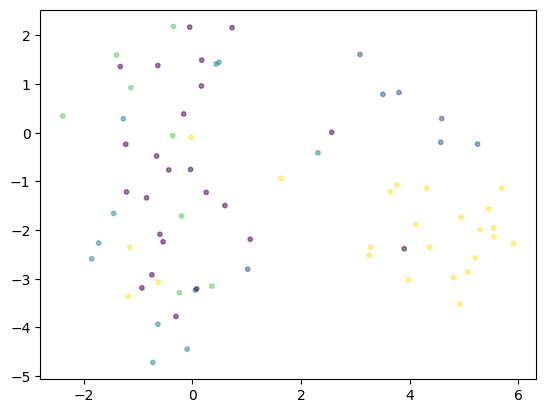

In [48]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.5 )


In [49]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=m_len, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [50]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 5
    for label in range(5):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [51]:
int_to_label={
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [52]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

test order dependency
test order dependency


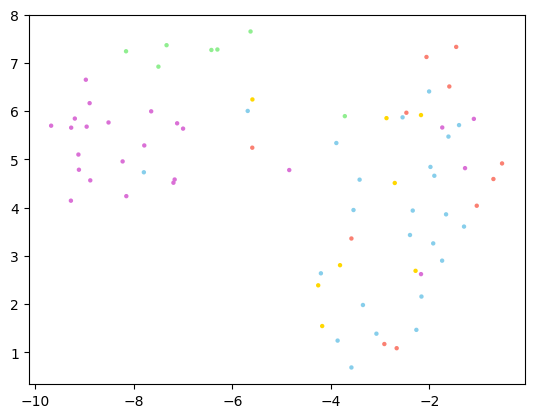

In [53]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# previous best result learing rate: 1e-5
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Scatter plot
for i, label in enumerate(labelsNums[:len(X_embedded)]):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
# legend_labels = list(shortened_labels.values())  # Use shortened labels for legend
# plt.legend(labels=legend_labels)

plt.show()


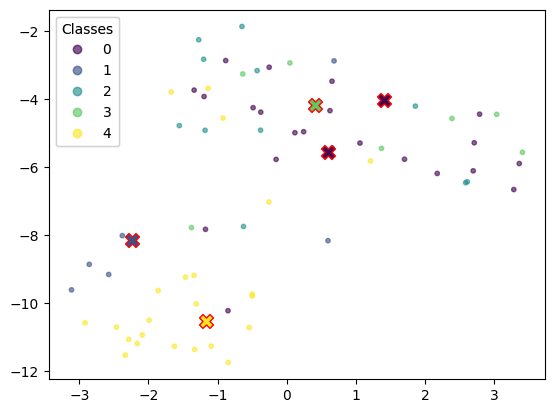

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [55]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# # Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# # Silhouette Score:
# # - Measures how similar an object is to its own cluster compared to other clusters.
# # - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
# #   A score close to 1 means that the clusters are well separated and clearly defined.
# silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Silhouette Score: {silhouette_avg}")

# # Davies-Bouldin Index:
# # - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
# #   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# # - Range: 0 to +∞. Lower scores indicate better clustering quality.
# davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Davies-Bouldin Index: {davies_bouldin}")

# # Calinski-Harabasz Index:
# # - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# # - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
# calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Calinski-Harabasz Index: {calinski_harabasz}")


In [56]:
    from sklearn.metrics import f1_score

    int_to_label={
        0: 'async wait',
        1: 'unordered collections',
        2: 'concurrency',
        3: 'time',
        4: 'test order dependency'
    }
    count = 0

    # Assuming val_dataset is iterable and has 'anchor' and 'label' keys
    predicted_labels = []
    true_labels = []

    for item in val_dataset:
        count+=1
        input_vector = item['anchor']  # Your input vector for prediction
        predicted_label = predict(input_vector)  # Get predicted cluster/label
        predicted_labels.append(predicted_label)
        
        true_label = item['label']  # True label
        true_label = int_to_label[int(true_label)]
        true_labels.append(true_label)
        print(count, " ",predicted_label, " " ,true_label)
    # Convert predicted labels to the same format as true_labels if necessary
    # This might include converting cluster IDs to the label format, depending on how your `predict` function outputs the prediction

    # Note: Ensure that your predict function returns labels in a format that matches true_labels or adjust accordingly
    print("loop completed")
    # Calculate F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Adjust 'average' as necessary
    print(f"F1 Score: {f1}")


1   test order dependency   test order dependency
2   unordered collections   unordered collections
3   time   time
4   time   async wait
5   test order dependency   test order dependency
6   async wait   async wait
7   time   unordered collections
8   concurrency   concurrency
9   unordered collections   time
10   async wait   concurrency
11   async wait   async wait
12   concurrency   test order dependency
13   async wait   concurrency
14   unordered collections   unordered collections
15   async wait   async wait
16   async wait   async wait
17   test order dependency   test order dependency
18   time   concurrency
19   concurrency   time
20   async wait   async wait
21   test order dependency   test order dependency
22   test order dependency   test order dependency
23   unordered collections   unordered collections
24   test order dependency   test order dependency
25   unordered collections   unordered collections
26   concurrency   async wait
27   test order dependency   test or

                       precision    recall  f1-score   support

           async wait       0.60      0.38      0.46        24
          concurrency       0.33      0.64      0.44        11
test order dependency       0.95      0.79      0.86        24
                 time       0.30      0.38      0.33         8
unordered collections       0.75      0.86      0.80         7

             accuracy                           0.59        74
            macro avg       0.59      0.61      0.58        74
         weighted avg       0.66      0.59      0.61        74


 - Accuracy :  0.59
 - Precision :  0.66
 - Recall :  0.59
 - F1 score :  0.61
 - MCC :  0.49
 - AUC :  0.75


Perfomnaces by categories



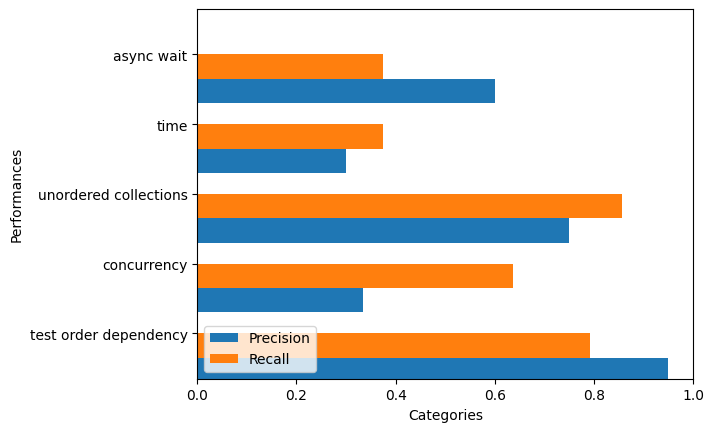



Confusion Matrix 


<AxesSubplot:>

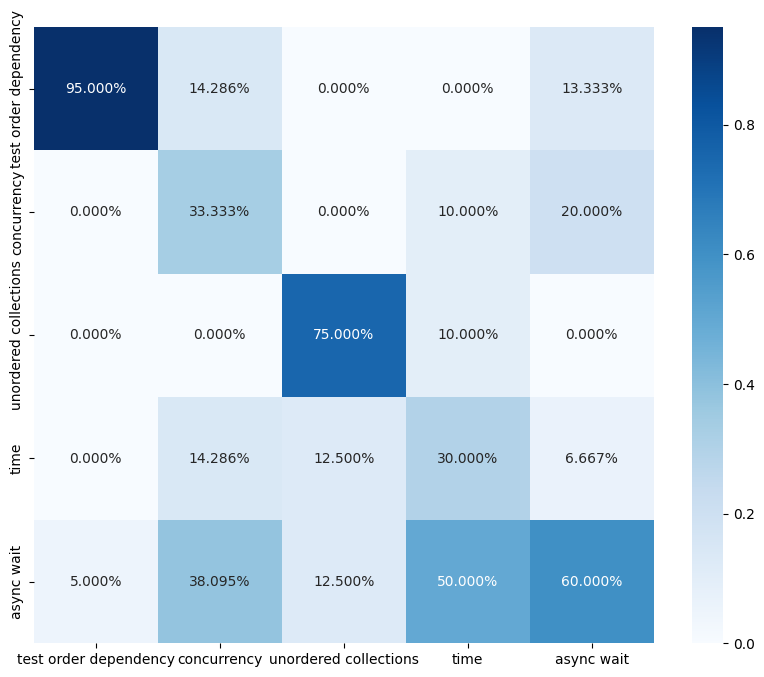

In [57]:
%matplotlib inline
warnings.filterwarnings("ignore")
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


predicted = predicted_labels
labels = true_labels
unique_labels = list ( set(labels ) )
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

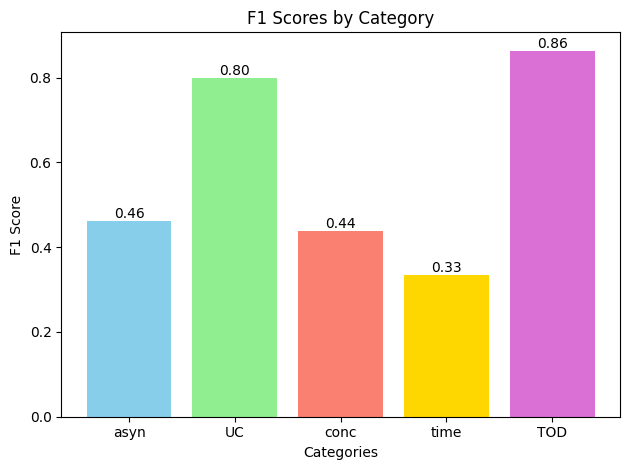

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
int_to_label = {
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}

# Shortened category names
shortened_labels = {
    'async wait': 'asyn',
    'unordered collections': 'UC',
    'concurrency': 'conc',
    'time': 'time',
    'test order dependency': 'TOD'
}

# Convert true and predicted labels back to integers for F1 score calculation
true_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in true_labels]
predicted_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in predicted_labels]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.values())
for category in categories:
    true_bin = [1 if label == category else 0 for label in true_labels]
    pred_bin = [1 if label == category else 0 for label in predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[category] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [59]:
# file_path = 'test_data_predictions.csv'

# # Load the compressed CSV file into a DataFrame
# df = pd.read_csv(file_path)

# # Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
# labels_flaky = df['TrueLabel'].tolist()
# predicted_flaky = df['PredictedLabel'].tolist()

# print (classification_report(labels, predicted))

# print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
# print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
# print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

# print("\n\nPerfomnaces by categories\n")


# ind = np.arange(len(unique_labels)) 
# width = 0.35
# fig, ax = plt.subplots()
# precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
# recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
# ax.barh(ind - width/2, precision, width, label='Precision')
# ax.barh(ind + width/2, recall, width, label='Recall')
# ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
# ylim=[2*width - 1, len(ind)])
# plt.xlim(0,1)
# ax.legend(loc='upper right')
# ax.set_xlabel("Performances")
# ax.set_ylabel("Categories")
# plt.show()

# print("\n\nConfusion Matrix ")

# mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
# df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
# plt.figure(figsize = (10,8))
# sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

In [60]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
# recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# # And assuming 'unique_labels' is defined as before

# ind = np.arange(len(unique_labels))  # the x locations for the groups
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# # Using a set of contrasting, darker colors
# colors = ['blue', 'green', 'red', 'orange']

# # Plotting Precision and Recall for Your Model
# rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
# rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# # Plotting Precision and Recall for Flaky Model
# rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
# rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# # Optional: Adding scores above bars
# ax.bar_label(rects1, padding=3, fmt='%.2f')
# ax.bar_label(rects2, padding=3, fmt='%.2f')
# ax.bar_label(rects3, padding=3, fmt='%.2f')
# ax.bar_label(rects4, padding=3, fmt='%.2f')

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

# plt.show()


In [61]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming metrics have been calculated and stored in variables for both models.
# # Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# # And similarly named variables with a '_flaky' suffix for the comparison model.

# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
# your_model_metrics = [
#     np.round(metrics.accuracy_score(labels, predicted), 2),
#     np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels, predicted), 2),
#     np.round(multiclass_roc_auc_score(labels, predicted), 2)
# ]

# flaky_model_metrics = [
#     np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
#     np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
#     np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
# ]

# x = np.arange(len(metrics_labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
# rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()


In [62]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# def extract_projections(siamese_network, dataloader):
#     projections = []
#     labels = []
#     for batch in dataloader:
#         label = batch["label"]
#         anchor = batch["anchor"]
#         projection = siamese_network(anchor)
        
#         projections.append(projection.cpu().detach().numpy())
#         labels.append(label.numpy())
#     projections = np.vstack(projections)
#     labels = np.hstack(labels)
#     return projections, labels

In [63]:
# projections, labels = extract_projections(siamese_network, train_dataloader)
# val_projections, val_labels = extract_projections(siamese_network, val_dataloader)

In [64]:
# print(len(projections), len(train_dataloader))

In [65]:
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier.fit(projections, labels)

# # Train SVM Classifier
# svm_classifier = SVC(kernel='linear', random_state=42)
# svm_classifier.fit(projections, labels)

In [66]:
# # Evaluate Random Forest Classifier
# rf_predictions = rf_classifier.predict(val_projections)
# rf_accuracy = accuracy_score(val_labels, rf_predictions)
# rf_f1 = f1_score(val_labels, rf_predictions, average='weighted')
# print(f"Random Forest Classifier Accuracy: {rf_accuracy}, F1: {rf_f1}")

# # Evaluate SVM Classifier
# svm_predictions = svm_classifier.predict(val_projections)
# svm_accuracy = accuracy_score(val_labels, svm_predictions)
# svm_f1 = f1_score(val_labels, svm_predictions, average='weighted')
# print(f"SVM Classifier Accuracy: {svm_accuracy}, F1:{svm_f1}")